This notebook is used for splitting data into train/val/test sets

In [1]:
# Change this to your local
ROOT_DIR = "/home/andreasabo/Documents/HNProject"

In [2]:
data_set_to_split_on = "at_least_one_target_and_labelled_view"
data_set_to_split_on = "labelled_view"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
csv_path = os.path.join(ROOT_DIR, "all_label_df.csv")
df = pd.read_csv(csv_path)
df.head()
split_names = ["at_least_one_target_and_labelled_view", "labelled_view"]
full_data_frame = df.copy()
# print(full_data_frame)
print(len(full_data_frame))

72459


In [5]:
def get_filepaths_to_img(dataset, image_dir):
    filepaths = pd.DataFrame()
    filepaths['paths'] = image_dir + dataset['subj_id'].map(str) + "_" + dataset['scan_num'].map(str) + "_" + dataset['image_num'].map(str) + ".jpg" 
    return filepaths


def split_data_based_on_patients(df_to_split, image_dir, train_ids, test_ids):
    train_set = df_to_split[df_to_split.subj_id.isin(train_ids)]
    test_set = df_to_split[df_to_split.subj_id.isin(test_ids)]
    
    train_filepaths = get_filepaths_to_img(train_set, image_dir)
    test_filepaths = get_filepaths_to_img(test_set, image_dir)

    return train_filepaths, test_filepaths, train_set, test_set


In [6]:
def calculate_scanner_proportion_diff(patient_scan_details, train, test):
    train_machine_counts = patient_scan_details[patient_scan_details.index.isin(train)]
    test_machine_counts = patient_scan_details[patient_scan_details.index.isin(test)]

    proportions_test = test_machine_counts.sum(axis=0) / test_machine_counts['img_count'].sum()
    proportions_train = train_machine_counts.sum(axis=0) / train_machine_counts['img_count'].sum()
    diff = abs(proportions_train - proportions_test)
    
    return diff.sum()

def calculate_outcome_proportion_diff(df, train, test):
    diff_sum = 0
    train_set = df[df.subj_id.isin(train)]
    test_set = df[df.subj_id.isin(test)]
    
    outcomes = ['reflux_label', 'surgery_label', 'function_label']

    for outcome in outcomes:
        train_set_counts = train_set[outcome].value_counts()
        test_set_counts = test_set[outcome].value_counts()
        
        train_count = len(train_set)
        test_count = len(test_set)
        
        if outcome == "function_label":
            # For function, we are only interested in missing vs. non-missing
            train_missing_frac = train_set_counts[train_set_counts.index == "Missing"] / train_count
            test_missing_frac = test_set_counts[test_set_counts.index == "Missing"] / test_count
            
            # Some mess
            train_no_missing = train_set_counts[train_set_counts.index != "Missing"]
            test_no_missing = test_set_counts[test_set_counts.index != "Missing"]
            train_no_missing = train_no_missing.reset_index()
            train_no_missing['function'] = train_no_missing['index']
            train_no_missing[["function"]] = train_no_missing[["function"]].apply(pd.to_numeric)

            
            test_no_missing = test_no_missing.reset_index()
            test_no_missing['function'] = test_no_missing['index']
            test_no_missing[["function"]] = test_no_missing[["function"]].apply(pd.to_numeric)
            
            
            train_good_frac = train_no_missing[(train_no_missing.function <= 60) & (train_no_missing.function >= 40)]
            test_good_frac = test_no_missing[(test_no_missing.function <= 60) & (test_no_missing.function >= 40)] 
            
            good_diff = abs((train_good_frac.function_label.sum() / train_count) \
                            - (test_good_frac.function_label.sum()/ test_count))
            
            
            train_bad_frac = train_no_missing[(train_no_missing.function > 60) | (train_no_missing.function < 40)]
            test_bad_frac = test_no_missing[(test_no_missing.function > 60) | (test_no_missing.function < 40)] 

            bad_diff = abs((train_bad_frac.function_label.sum() / train_count) \
                            - (test_bad_frac.function_label.sum()/ test_count))
            
            # This is proportion missing vs. not
            new_diff = list(abs(train_missing_frac - test_missing_frac))[0]

            
            diff_sum = diff_sum + new_diff + good_diff + bad_diff
        else:
            train_set_counts = train_set_counts/ train_count
            test_set_counts = test_set_counts/ test_count
            
            new_diff = abs(test_set_counts - train_set_counts).sum() / 2
            
            diff_sum += new_diff
            
    return diff_sum


def select_split(df, patient_scan_details, test_percentage=0.2, num_trials=1000000):
    # Just intialize to large value, this will be overwritten in the first iteration
    lowest_diff = 100
    lowest_diff_seed = 0
    
    # Sample many trials, and then select the one with the smallest difference in proportions
    for i in range(num_trials):
        patients = df.subj_id.unique()
        train, test = train_test_split(patients, test_size=test_percentage, random_state=i)
        cur_diff_scanner = calculate_scanner_proportion_diff(patient_scan_details, train, test)
        cur_diff_label = calculate_outcome_proportion_diff(df, train, test)
        
        if data_set_to_split_on == "labelled_view":
            cur_diff = cur_diff_scanner
        else:
            cur_diff = cur_diff_label + cur_diff_scanner
        # if this split has the lowest proportions, remember it
        if cur_diff < lowest_diff:
            lowest_diff = cur_diff
            lowest_diff_seed = i
        if i % 1000 == 0:
            print(i)
    print("Best config: ",lowest_diff, lowest_diff_seed)
    
    # Split on the best random state we found
    train, test = train_test_split(patients, test_size=test_percentage, random_state=lowest_diff_seed)
    cur_diff = calculate_scanner_proportion_diff(patient_scan_details, train, test)
    return train, test
    
    


In [7]:
for split in range(len(split_names)):
    data_set_to_split_on = split_names[split]
    # Define the df of images we want to consider as the entire dataset
    if data_set_to_split_on == "at_least_one_target_and_labelled_view":
        labelled_view_df = df[(df.view_label != "Missing") & (df.view_label != "Other")]
        frame_to_split = labelled_view_df[(labelled_view_df.function_label != "Missing") | (labelled_view_df.reflux_label != "Missing") | (labelled_view_df.surgery_label != "Missing")]

    elif  data_set_to_split_on == "labelled_view":
        frame_to_split = df[(df.view_label != "Missing")]
    elif 0: # Replace this with other datasets as we define them
        pass
    else:
        raise Exception("Invalid data to split on!")


    # Some QA to make sure the dataset we are using is what we expect it to be
    frame_to_split_count = frame_to_split.groupby('subj_id').scan_num.agg(['nunique'])
    print(f"There are {len(frame_to_split)} from {frame_to_split_count['nunique'].sum()} scans from {frame_to_split.subj_id.nunique()} patients in this dataframe.")
    print(frame_to_split.columns)


    # Add image counts and percentage of total images that belong to each patient
    patient_scan_details = frame_to_split.groupby('subj_id').image_num.agg(img_count='count')
    patient_scan_details['img_percent_count'] = patient_scan_details['img_count'] / patient_scan_details['img_count'].sum()

    # Calculate percent (of all images) that were taken by each machine for each patient 
    machine_labels = dict(frame_to_split['image_manu'].value_counts())
    for machine in machine_labels:
        this_machine = frame_to_split[frame_to_split['image_manu'] == machine]
        this_machine_count = this_machine.groupby('subj_id').image_manu.count()
    #     patient_scan_details["percent_" + machine] = this_machine.groupby('subj_id').image_manu.count() / len(frame_to_split)
        patient_scan_details[machine] = this_machine.groupby('subj_id').image_manu.count()

    # Replace nans with 0s because they're easier to work with
    patient_scan_details = patient_scan_details.fillna(0)
    print(patient_scan_details.sum(axis = 0))
    
    train_subjs, test_subjs = select_split(frame_to_split, patient_scan_details)
          
          
    train_filepaths, test_filepaths, train_set, test_set = split_data_based_on_patients(frame_to_split, os.path.join(ROOT_DIR, 'all_label_img/'), train_subjs, test_subjs)  

          
    if data_set_to_split_on == "at_least_one_target_and_labelled_view":
        output_name = 'outcome_train'
    elif  data_set_to_split_on == "labelled_view": 
        output_name = 'view_train'
    # Add all of these labels to the overall dataframe
    full_data_frame[output_name] = np.nan
    train_image_inds = full_data_frame[full_data_frame.image_ids.isin(train_set.image_ids)].index
    test_image_inds = full_data_frame[full_data_frame.image_ids.isin(test_set.image_ids)].index

    full_data_frame.loc[ train_image_inds , output_name ] = 1
    full_data_frame.loc[ test_image_inds , output_name ] = 0
          
full_data_frame.to_csv(os.path.join(ROOT_DIR, 'all_splits_1000000.csv'))

There are 9581 from 230 scans from 71 patients in this dataframe.
Index(['Unnamed: 0', 'num_in_seq', 'function_label', 'image_acq_date',
       'image_acq_time', 'image_ids', 'image_manu', 'reflux_label',
       'surgery_label', 'view_label', 'subj_id', 'scan_num', 'image_num'],
      dtype='object')
img_count                   9581.0
img_percent_count              1.0
Philips Medical Systems     5119.0
TOSHIBA_MEC                 3599.0
ATL                          260.0
ACUSON                       219.0
SAMSUNG MEDISON CO.,LTD.     133.0
TOSHIBA_MEC_US               125.0
GE Medical Systems            83.0
GE Healthcare                 43.0
dtype: float64
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
5700

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [8]:
full_data_frame.head()

,Unnamed: 0,num_in_seq,function_label,image_acq_date,image_acq_time,image_ids,image_manu,reflux_label,surgery_label,view_label,subj_id,scan_num,image_num,outcome_train,view_train
0,0,0,Missing,20171212,111745.0,1323_2_1,Philips Medical Systems,Missing,Missing,Missing,1323,2,1,NaN,NaN
1,1,1,Missing,20171212,111803.0,1323_2_2,Philips Medical Systems,Missing,Missing,Missing,1323,2,2,NaN,NaN
2,2,2,Missing,20171212,111807.0,1323_2_3,Philips Medical Systems,Missing,Missing,Missing,1323,2,3,NaN,NaN
3,3,3,Missing,20171212,111820.0,1323_2_4,Philips Medical Systems,Missing,Missing,Missing,1323,2,4,NaN,NaN
4,4,4,Missing,20171212,111824.0,1323_2_5,Philips Medical Systems,Missing,Missing,Missing,1323,2,5,NaN,NaN


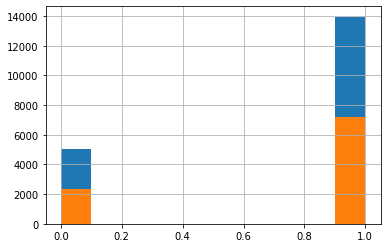

In [9]:
full_data_frame.view_train.hist()
full_data_frame.outcome_train.hist()

In [10]:

    
# train_filepaths, test_filepaths, train_set, test_set = split_data_based_on_patients(frame_to_split, os.path.join(ROOT_DIR, 'all_label_img/'), train_subjs, test_subjs)  

# # Add all of these labels to the overall dataframe
# full_data_frame['view_train'] = np.nan
# train_image_inds = full_data_frame[full_data_frame.image_ids.isin(train_set.image_ids)].index
# test_image_inds = full_data_frame[full_data_frame.image_ids.isin(test_set.image_ids)].index

# full_data_frame.loc[ train_image_inds , 'view_train' ] = 1
# full_data_frame.loc[ test_image_inds , 'view_train' ] = 0

# full_data_frame.view_train.hist()

# full_data_frame['view_train']  = full_data_frame[full_data_frame.image_ids.isin(train_set.image_ids)]

# print(full_data_frame[full_data_frame.image_ids.isin(train_set.image_ids)].index)
# print(full_data_frame.head())
# print(full_data_frame)

# # train_filepaths.to_csv(os.path.join(ROOT_DIR, 'train_filepaths_view_balanced_20.csv'))
# # test_filepaths.to_csv(os.path.join(ROOT_DIR, 'test_filepaths_view_and_balanced_20.csv'))
# full_data_frame.view_train.hist()
# print(len(train_set))
# print(len(test_set))

In [11]:
# full_data_frame.subj_id.isin(train_subjs)
# x = full_data_frame.subj_id.isin(train_subjs)
# print(full_data_frame.subj_id.isin(train_subjs))
# x.hist()
# print()

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

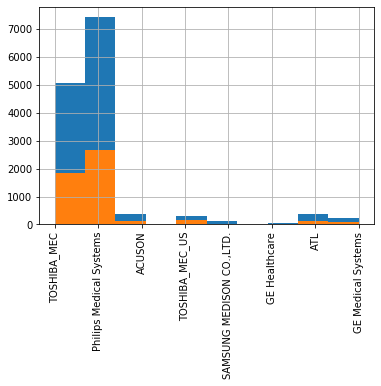

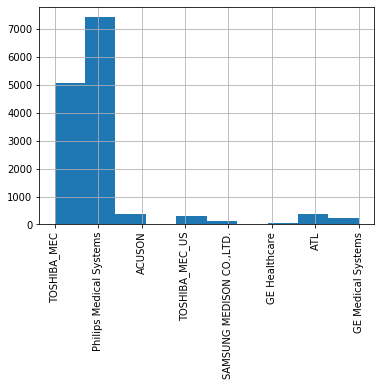

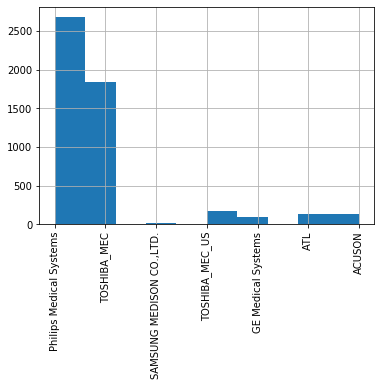

In [12]:
plt.figure()
train_set.image_manu.hist()
test_set.image_manu.hist()
plt.xticks(rotation=90)
plt.figure()
train_set.image_manu.hist()
plt.xticks(rotation=90)
plt.figure()
test_set.image_manu.hist()
plt.xticks(rotation=90)